# Setup Libraries

Needed in google colab

In [1]:
pip install yfinance

     |████████████████████████████████| 6.4 MB 10.4 MB/s 
     |████████████████████████████████| 63 kB 1.1 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [2]:
# Provides ways to work with large multidimensional arrays
import numpy as np 
# Allows for further data manipulation and analysis
import pandas as pd 
import matplotlib.pyplot as plt # Plotting
import matplotlib.dates as mdates # Styling dates
#import matplotlib.mlab as mlab 
%matplotlib inline

# statistical calculation
#from scipy.stats import norm

import datetime as dt # For defining dates

import time

import yfinance as yf

# Get Stock Data

In [3]:
all_stocks = ["^GSPC", "^FTLC", "^RUT", "IEUS", "GOVT", "IGOV", "SIVR", "SGOL"]

In [4]:
def get_all_closes_of_stocks(tickers):
  i = 0
  stock_list = pd.DataFrame()
  for ticker in tickers:
    stock = yf.Ticker(ticker)        
    data = stock.history(start="2012-02-24",end ="2022-02-25")
    data.drop(data.columns[[0,1,2,4,5,6]], axis=1, inplace=True) # Just gets the adjacent close for each asset
    data.columns = [ticker]
    stock_list[ticker] = data.iloc[:,0]
  return stock_list.dropna()
stock_data = get_all_closes_of_stocks(all_stocks)
print(stock_data)

                  ^GSPC        ^FTLC         ^RUT       IEUS       GOVT  \
Date                                                                      
2012-02-24  1365.739990  3144.399902   826.919983  27.285172  21.551901   
2012-02-27  1367.589966  3133.399902   826.659973  27.201176  21.551901   
2012-02-28  1372.180054  3141.199951   823.799988  27.445543  21.551901   
2012-02-29  1365.680054  3112.399902   810.940002  27.155352  21.551901   
2012-03-01  1374.089966  3142.899902   815.219971  27.117170  21.551901   
...                 ...          ...          ...        ...        ...   
2022-02-17  4380.259766  4240.200195  2028.089966  63.590000  25.511517   
2022-02-18  4348.870117  4222.799805  2009.329956  62.840000  25.571404   
2022-02-22  4304.759766  4201.799805  1980.170044  61.560001  25.581383   
2022-02-23  4225.500000  4198.799805  1944.089966  60.889999  25.461611   
2022-02-24  4288.700195  4042.899902  1996.010010  60.000000  25.471592   

                 IGOV   

# Pytorch Clean start

## Data Preprocessing

In [5]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

Length references the number of values in a single sample. It would be 8 for me

Predicting the next value using the half a years worth of input data

Use price change and maybe some standarsation like standard scaling 

Use pct_change(). That'll give me normalised daily returns change

Try just standerising the values

In [6]:
norm_stock_data = stock_data.pct_change().dropna() # Gives us a % change
norm_stock_data = norm_stock_data.to_numpy()

test_size = 252
validate_size = 252

In [7]:
print(norm_stock_data.shape)

(2400, 8)


### Remove test year from data

We don't want to train on the test year

In [8]:
test_stock_data = norm_stock_data[-test_size*2:-test_size] ## This is the year previous the test year that we will actually input into the LSTM to make a prediction on the test year

In [9]:
norm_stock_data = norm_stock_data[:-test_size]

In [10]:
print(norm_stock_data.shape)
#print(norm_stock_data[2399])

(2148, 8)


### Setup Train data

In [32]:
trainX = []
trainY = []

n_future = 252 # Could do 252 days tested it on 20  # Number of days we want to look into the future based on the past days.
n_past = 252 # Could do 252 days tested it on 126 # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(norm_stock_data) - n_future +1):
    trainX.append(norm_stock_data[i - n_past:i, 0:norm_stock_data.shape[1]])
    trainY.append(norm_stock_data[i + n_future - 1:i + n_future, 0:norm_stock_data.shape[1]])
trainX, trainY = np.array(trainX), np.array(trainY)

In [12]:
print(trainX.shape)
print(trainY[0])

(1645, 252, 8)
[[-0.0117011  -0.00989251 -0.01227998 -0.00869408  0.00203645  0.00155119
  -0.00523563  0.00334897]]


### Test Year

To actually predict the asset allocation for the test year we need to input the year previous the test year. Here we just format it

In [13]:
test_stock_data = np.expand_dims(test_stock_data, axis = 0)
test_stock_data.shape

(1, 252, 8)

## Pytorch Dataset

In [14]:
class StockDataset(Dataset):
  def __init__(self, sequences, labels):
    self.sequences = sequences
    self.labels = labels
  def __len__ (self):
    return len(self.sequences)
  def __getitem__(self, idx):
    sequence = torch.tensor(self.sequences[idx], dtype=torch.double)
    label = torch.tensor(self.labels[idx], dtype=torch.double)# Add .float if needed
    return sequence, label

In [15]:
train_dataset = StockDataset(trainX, trainY)

In [16]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=25, shuffle=False, num_workers=1)

## Weight Prediction Model

## Custom Loss Function. Calculates the Sharpe ratio for the y range prediction

In [17]:
def portfolio_returns(weights, y):
  return torch.sum(torch.mul(weights, y), dim=2) # Calculate the return over the timestep I'm not doing logs

In [18]:
def sharpe_ratio_loss(weights, future_values, rf = 0.00): # representing the evolution over the next `horizon` timesteps.
  predicted_returns = torch.sum(torch.mul(weights, future_values), dim=2)
  #print(predicted_returns)
  return -(torch.mean(predicted_returns,dim=0) - rf) / (torch.std(predicted_returns,dim=0))
class SharpeRatioMSE(nn.Module):
  def __init__(self):
    super(SharpeRatioMSE,self).__init__()
  def forward(self, input, target):
    return sharpe_ratio_loss(input,target)

### Define the model

n_hidden is the hidden number of features in the LSTM

Features are the number of stocks I will be using

batch_first – If True, then the input and output tensors are provided as (batch, seq, feature) instead of (seq, batch, feature). Note that this does not apply to hidden or cell states. See the Inputs/Outputs sections below for details. Default: False

num_layers – Number of recurrent layers. E.g., setting num_layers=2 would mean stacking two LSTMs together to form a stacked LSTM, with the second LSTM taking in outputs of the first LSTM and computing the final results. Default: 1

a sequence of 126 datapoints in each batch containing 8 features each

In [19]:
class MV_LSTM(torch.nn.Module):  
  def __init__(self,n_features,seq_length):
    super(MV_LSTM, self).__init__()
    self.n_features = n_features
    self.seq_len = seq_length
    self.n_hidden = 50 # number of hidden states
    self.n_layers = 1 # number of LSTM layers (stacked)

    self.l_lstm = torch.nn.LSTM(input_size = n_features, 
                              hidden_size = self.n_hidden,
                              num_layers = self.n_layers, 
                              batch_first = True)
    # according to pytorch docs LSTM output is 
    # (batch_size,seq_len, num_directions * hidden_size)
    # when considering batch_first = True
    self.l_linear = torch.nn.Linear(self.n_hidden*self.seq_len, 8)
    self.softmax = torch.nn.Softmax(dim=1)

    
  def init_hidden(self, batch_size):
    # even with batch_first = True this remains same as docs
    hidden_state = torch.zeros(self.n_layers,batch_size,self.n_hidden)
    cell_state = torch.zeros(self.n_layers,batch_size,self.n_hidden)
    self.hidden = (hidden_state, cell_state)
    
    
  def forward(self, x):
    #print("x")
    #print(x.shape) 
    batch_size, seq_len, _ = x.size()

    lstm_out, self.hidden = self.l_lstm(x,self.hidden)
    #print("x")
    #print(x.shape) 
    # lstm_out(with batch_first = True) is 
    # (batch_size,seq_len,num_directions * hidden_size)
    # for following linear layer we want to keep batch_size dimension and merge rest       
    # .contiguous() -> solves tensor compatibility error
    #print(x.shape)
    x = lstm_out.contiguous().view(batch_size,-1)

    x = self.l_linear(x)
    #print(x.shape)
    #print(x)
    #
    weights = self.softmax(x)
    return weights

### Initialisation

In [62]:
n_features = 8 # this is number of parallel inputs
n_timesteps = 252 # this is number of timesteps

# create NN
mv_net = MV_LSTM(n_features,n_timesteps)
mv_net = mv_net.double()
torch.set_default_tensor_type(torch.DoubleTensor)

In [21]:
print(mv_net)

MV_LSTM(
  (l_lstm): LSTM(8, 50, batch_first=True)
  (l_linear): Linear(in_features=12600, out_features=8, bias=True)
  (softmax): Softmax(dim=1)
)


### Pytorch training Loop

It looks like without the shuffle that it does it in sequence meaning I should be able to track what date it is and calculate the 

In [63]:
#criterion = torch.nn.MSELoss() # reduction='sum' created huge loss value
#optim = torch.optim.Adam(mv_net.parameters(), lr=0.18)#1e-1
optim = torch.optim.SGD(mv_net.parameters(), lr = 0.23) # Defines the optimiser  0.2-0.25 works quite well
criterion = SharpeRatioMSE()

In [64]:
num_epochs = 30

Sometimes it gets very jumpy and doesn't converge restart if it does that

In [65]:
mv_net.train()
for epoch in range(num_epochs): # Loops through all epochs
  total_loss = 0
  for i, (sequences, labels) in enumerate(train_loader): # Loops through all batches of the epoch
    mv_net.init_hidden(sequences.size(0))
    #print(sequences.shape)
    #print(sequences.shape)
    output = mv_net(sequences) # Uses the model to predict the output
    #print(labels)
    #loss.requires_grad = True
    print(output)
    #tmp_test = output
    #print(labels)
    loss = criterion(output.unsqueeze(dim=1), labels) # Calculates the loss for the batch
    #print(loss)
    loss.backward() # Calculates the backwars propagation
    optim.step() # Adjusts the network
    optim.zero_grad() # Resets the gradients of the optimiser
    total_loss += loss.detach().numpy()[0]
  print('Total loss over epoch {}: {:.2f}'.format(epoch+1,total_loss))

Streaming output truncated to the last 5000 lines.
        [0.5066, 0.0104, 0.0169, 0.0287, 0.4076, 0.0169, 0.0046, 0.0083],
        [0.5066, 0.0104, 0.0169, 0.0287, 0.4076, 0.0169, 0.0046, 0.0083],
        [0.5067, 0.0104, 0.0169, 0.0287, 0.4076, 0.0169, 0.0046, 0.0083],
        [0.5066, 0.0104, 0.0169, 0.0286, 0.4078, 0.0169, 0.0046, 0.0083],
        [0.5061, 0.0104, 0.0169, 0.0286, 0.4082, 0.0169, 0.0046, 0.0083],
        [0.5058, 0.0104, 0.0169, 0.0286, 0.4086, 0.0169, 0.0046, 0.0083],
        [0.5060, 0.0104, 0.0169, 0.0286, 0.4084, 0.0169, 0.0046, 0.0083],
        [0.5059, 0.0104, 0.0169, 0.0287, 0.4084, 0.0169, 0.0046, 0.0083],
        [0.5062, 0.0104, 0.0169, 0.0286, 0.4081, 0.0169, 0.0046, 0.0083],
        [0.5066, 0.0104, 0.0169, 0.0286, 0.4077, 0.0169, 0.0046, 0.0083],
        [0.5066, 0.0104, 0.0169, 0.0287, 0.4077, 0.0169, 0.0046, 0.0083],
        [0.5069, 0.0104, 0.0169, 0.0287, 0.4073, 0.0169, 0.0046, 0.0083],
        [0.5075, 0.0104, 0.0169, 0.0287, 0.4068, 0.0169, 0.00

## Get the Test Year Predicted Portfolio Weights

Format the year previous to the test year so that we make a test year prediction

In [73]:
test_year = torch.tensor(test_stock_data,dtype=torch.double)
test_year.size(0)

1

In [74]:
print(test_year.size(0))

1


In [75]:
mv_net.eval()
mv_net.init_hidden(test_year.size(0))
with torch.no_grad():
  y_predict = mv_net(test_year)
  print(y_predict)
weights = y_predict.numpy()
portfolio_weights = pd.DataFrame(weights,columns=all_stocks)
portfolio_weights = portfolio_weights.iloc[0,:]
portfolio_weights

tensor([[0.1788, 0.0861, 0.1078, 0.1172, 0.2901, 0.0952, 0.0582, 0.0666]])


^GSPC    0.178793
^FTLC    0.086132
^RUT     0.107795
IEUS     0.117159
GOVT     0.290114
IGOV     0.095159
SIVR     0.058220
SGOL     0.066628
Name: 0, dtype: float64

# Benchmark the Test Year

In [80]:
initial_investment = 10000 # 10'000 dollar invesment. Can Change to 100'000 later 
trading_year = 252 # Number of trading days in a year
stock_returns = stock_data.pct_change() 

In [81]:
weighted_portfolio = portfolio_weights * initial_investment # Calculate the dollars invested in each asset in the portfolio
num_of_shares = weighted_portfolio / stock_data.iloc[(-trading_year),:] # Calculate the number of shares owned of each asset in the portfolio
portfolio_test_values = num_of_shares * stock_data.iloc[(-trading_year):,:] # share * share price = position value and it is done for each day in the trading year for all assets
portfolio_test_values['Total'] = portfolio_test_values.sum(axis=1)
portfolio_test_values

,^GSPC,^FTLC,^RUT,IEUS,GOVT,IGOV,SIVR,SGOL,Total
Date,,,,,,,,,
2021-02-04,1787.929284,861.322498,1077.948883,1171.587117,2901.136767,951.594897,582.197505,666.283048,10000.000000
2021-02-05,1794.897730,861.692138,1093.077501,1183.842536,2896.834188,956.002931,593.402445,672.853127,10052.602596
2021-02-08,1808.178804,865.550001,1120.696476,1190.244568,2897.909833,957.060797,603.921311,679.423207,10122.984997
2021-02-09,1806.165351,866.612615,1125.218882,1195.732239,2900.061123,962.879365,600.948601,681.355553,10138.973729
2021-02-10,1805.541890,864.949351,1117.113754,1190.244568,2905.439762,961.645132,596.603831,684.060940,10125.599228
...,...,...,...,...,...,...,...,...,...
2022-02-17,2022.758431,979.530595,992.625108,1193.965185,2776.371940,857.410775,525.029641,704.157589,10051.849266
2022-02-18,2008.263018,975.510923,983.443239,1179.883193,2782.889326,856.348790,526.859055,703.384695,10016.582239
2022-02-22,1987.893316,970.659704,969.171258,1155.849949,2783.975350,855.463780,531.889811,704.930557,9959.833725


### Plot the portfolio

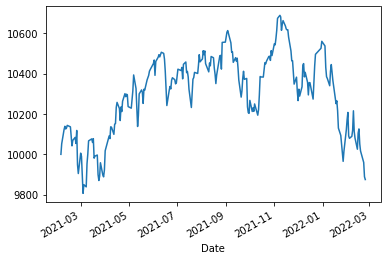

In [82]:
portfolio_test_values['Total'].plot() # Need to pretty this up for the dssertation or not use it at all

### Plot the Individual Assets

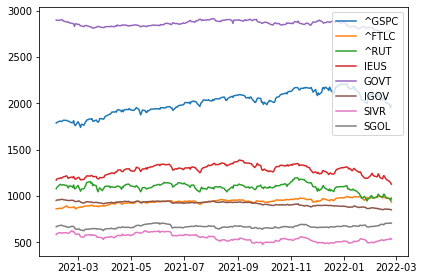

In [83]:
# Plotted on the same graph to see general trend
figure = plt.figure()
axis = plt.plot(portfolio_test_values.iloc[:,0:1], label='^GSPC')
axis = plt.plot(portfolio_test_values.iloc[:,1:2], label='^FTLC')
axis = plt.plot(portfolio_test_values.iloc[:,2:3], label='^RUT')
axis = plt.plot(portfolio_test_values.iloc[:,3:4], label='IEUS')

axis = plt.plot(portfolio_test_values.iloc[:,4:5], label='GOVT')
axis = plt.plot(portfolio_test_values.iloc[:,5:6], label='IGOV')
axis = plt.plot(portfolio_test_values.iloc[:,6:7], label='SIVR')
axis = plt.plot(portfolio_test_values.iloc[:,7:8], label='SGOL')
plt.tight_layout()
plt.legend()
plt.show()

# Analyse the Test Year

## Sharpe Ratio

^GSPC    0.775173
^FTLC    0.693307
^RUT    -0.311277
IEUS    -0.162606
GOVT    -0.831363
IGOV    -1.651280
SIVR    -0.269970
SGOL     0.487029
Total   -0.109219
dtype: float64

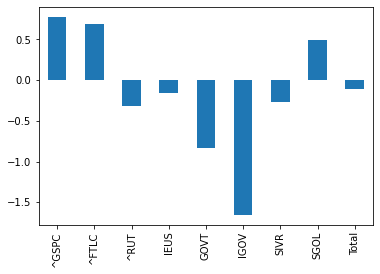

In [84]:
#daily_stock_returns = portfolio_position_values.pct_change().dropna() # Analysing holding such portfolio position from the start
daily_stock_returns = portfolio_test_values.pct_change().dropna()
#print(daily_stock_returns.iloc[250,:-1])
# To calculate sharpie ratio for individual stocks 
def sharpe_ratio(return_series, N, rf):
    mean = return_series.mean() * N -rf
    sigma = return_series.std() * np.sqrt(N)
    return mean / sigma

N = 252 #252 trading days in a year
rf =0 #1% risk free rate Will need to update this to the US treasury field or something. I assume this to be 0 in my dissertation
#The risk-free rate could be a U.S. Treasury rate or yield, such as the one-year or two-year Treasury yield.
sharpes = daily_stock_returns.apply(sharpe_ratio, args=(N,rf,),axis=0)
#total_stock_returns = daily_stock_returns.iloc[250,:-1]
#sharpes2 = sharpe_ratio(total_stock_returns, N, rf)
#print(total_stock_returns)
# Need to look at the returns which price doesn't give
#print(portfolio_test_values.iloc[251:252,:].drop(["date"],axis=1))
#print(portfolio_test_values.iloc[251:252,:].reset_index().drop("Date", axis=1))
#val_returns = (portfolio_test_values.iloc[251:252,:].reset_index().drop("Date", axis=1) - portfolio_test_values.iloc[0:1,:].reset_index().drop("Date", axis=1) ) /  portfolio_test_values.iloc[0:1,:].reset_index().drop("Date", axis=1)
#print(portfolio_test_values.diff())
#sharpes2 = portfolio_test_values.diff().apply(sharpe_ratio, args=(N,rf,),axis=0)
#print(sharpes2)
sharpes.plot.bar()
sharpes

## Volatility

### Individual Stock Volatility

#### Rolling Volatilty for Each stock

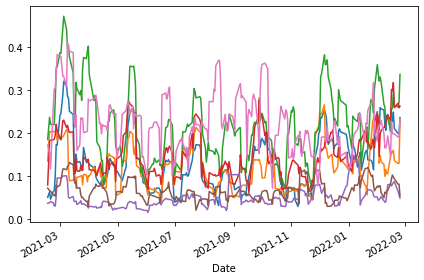

In [85]:
#data = portfolio_position_values.pct_change().dropna() # Analysing holding such portfolio position from the start
rolling_stock = pd.DataFrame()
data = portfolio_test_values.pct_change().dropna()
for stock in all_stocks:
  rolling_stock[stock] = data[stock].rolling(7).std()*(252**0.5)
f1 = plt.figure()
for i in range(0,7):
  rolling_stock.iloc[:,i].plot()
  plt.tight_layout()
  #plt.show() # To display in separate graphs instead of 1

#### Anualised volatility for Each Stock

In [86]:
#data = portfolio_position_values.pct_change().dropna() # Analysing holding such portfolio position from the start
stock_volatility = pd.DataFrame()
data = portfolio_test_values.pct_change().dropna()
tmp = pd.DataFrame()
i = 0 
for stock in all_stocks:
  tmp[stock] = data.iloc[:,i:(i+1)]
  stock_volatility = tmp.std()*(252**0.5)
  i = i + 1
print(stock_volatility)

^GSPC    0.146273
^FTLC    0.129323
^RUT     0.231481
IEUS     0.161712
GOVT     0.053270
IGOV     0.068009
SIVR     0.233521
SGOL     0.131792
dtype: float64


### Portfolio Volatility

#### Just the Anualised Volatility for the Portfolio

In [87]:
total_portfolio_change = portfolio_test_values['Total'].pct_change().dropna()
portfolio_vol = total_portfolio_change.std()*(252**0.5)
portfolio_vol

0.08359245279741512

## Maximum Drawdown

^GSPC   -0.118501
^FTLC   -0.065139
^RUT    -0.209376
IEUS    -0.187752
GOVT    -0.053062
IGOV    -0.118520
SIVR    -0.240117
SGOL    -0.097056
Total   -0.076127
dtype: float64

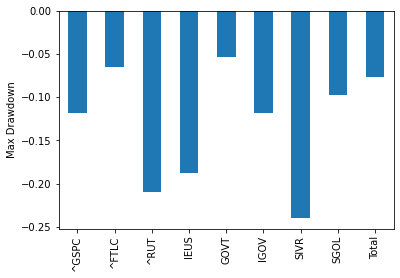

In [88]:
def max_drawdown(return_series):
    comp_ret = (return_series+1).cumprod()
    peak = comp_ret.expanding(min_periods=1).max()
    dd = (comp_ret/peak)-1
    return dd.min()

daily_stock_returns = portfolio_test_values.pct_change().dropna()
max_drawdowns = daily_stock_returns.apply(max_drawdown,axis=0)
max_drawdowns.plot.bar()
plt.ylabel('Max Drawdown')
max_drawdowns

## Compound Annual Growth Rate (CARG)

In [89]:
start_value = portfolio_test_values.iloc[0,:]
end_value = portfolio_test_values.iloc[-1,:]
number_of_years =  round(len(portfolio_test_values)/252)
CARG = (((end_value / start_value) ** (1/number_of_years)) -1)# Shows % of values
CARG

^GSPC    0.107693
^FTLC    0.084323
^RUT    -0.093720
IEUS    -0.038433
GOVT    -0.044503
IGOV    -0.107903
SIVR    -0.086017
SGOL     0.056845
Total   -0.012487
dtype: float64

## Calmar Ratio

^GSPC    0.968235
^FTLC    1.392832
^RUT    -0.348238
IEUS    -0.141721
GOVT    -0.844546
IGOV    -0.958821
SIVR    -0.265680
SGOL     0.669212
Total   -0.121357
dtype: float64

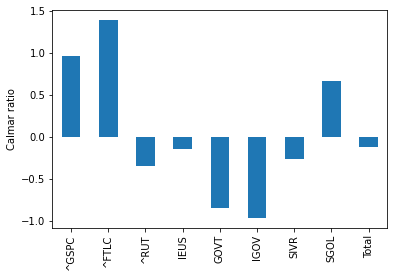

In [90]:
#daily_stock_returns = portfolio_position_values.pct_change().dropna() # Analysing holding such portfolio position from the start
daily_stock_returns = portfolio_test_values.pct_change().dropna()

calmars = daily_stock_returns.mean()*255/abs(max_drawdowns)

calmars.plot.bar()
plt.ylabel('Calmar ratio')
calmars

## Value at Risk? Haven't decided if I want to include this or not

# Export the Benchmark for the Test Year to a CSV

In [91]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [92]:
portfolio_test_values.to_csv('LSTMModelData.csv')

In [93]:
portfolio_weights.to_csv('LSTMModelWeights.csv')

In [94]:
!cp LSTMModelData.csv "drive/My Drive/DisData"

In [95]:
!cp LSTMModelWeights.csv "drive/My Drive/DisData"